In [1]:
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent) + "/code/")
from utils import *
import pyreadr

# Testing notebook `05_estimate_land_sink`

## 1. Load data

In [2]:
# load global GCB data
GCB_data = pd.read_excel('../data/carbon_cycle/GCB/Global_Carbon_Budget_2023v1.1.xlsx',sheet_name='Global Carbon Budget',skiprows=21,index_col=0)*1e15

# load inversion data
GCB_inversions = xr.open_dataset('../data/carbon_cycle/atmospheric_inversions/GCP2023_inversions_1x1_version1_1_20240124.nc')

# set CRS and rename dimensions
GCB_inversions.rio.write_crs("EPSG:4326",inplace=True);
GCB_inversions = GCB_inversions.rename({'longitude':'x','latitude':'y'})

# get the inversion names and assign them as coordinates
inversion_names = np.array([''.join(GCB_inversions['ensemble_member_name'].values[i]) for i in range(GCB_inversions.sizes['ensemble_member'])])
GCB_inversions = GCB_inversions.assign_coords({'ensemble_member':inversion_names})

# get the grid cell area
cell_area = GCB_inversions['cell_area']

## 2. Run analysis

In [59]:
global_NEE.mean().loc[1990:]

time
1990   -1.520583
1991   -2.331770
1992   -2.687963
1993   -2.087848
1994   -0.895326
1995   -0.872663
1996   -2.355953
1997   -0.821931
1998    0.511072
1999   -2.205875
2000   -2.531827
2001   -1.939191
2002   -0.590412
2003   -1.171172
2004   -2.459333
2005   -1.121949
2006   -2.479675
2007   -1.807651
2008   -3.179237
2009   -2.709086
2010   -1.665921
2011   -3.343703
2012   -1.757692
2013   -2.305879
2014   -2.940083
2015   -1.348630
2016   -1.115112
2017   -2.752213
2018   -2.705843
2019   -1.879432
2020   -1.939093
2021   -2.531271
2022   -3.338188
dtype: float64

In [61]:
# get NEE data and calculate annual global flux
NEE = GCB_inversions['land_flux_only_fossil_cement_adjusted'].resample(time='YE').mean()
NEE['time'] = NEE['time.year']
global_NEE = (NEE*cell_area).sum(dim=['x','y']).to_series().unstack()
global_NEE[global_NEE==0] = np.nan

# calculate global lateral flux
global_lateral = (GCB_inversions['river_adjustment_land_scaled']*cell_area).sum(dim=['x','y'])

# calculate global NBP
global_nbp = - global_NEE - global_lateral.values

In [43]:
# calculate the land sink from the anthropogenic perturbation fluxes
land_sink = GCB_data['fossil emissions excluding carbonation'] - GCB_data['atmospheric growth'] - GCB_data['ocean sink'] - GCB_data['cement carbonation sink']
F_lat_anth = 0.05e15
land_sink_nbp = land_sink - F_lat_anth

Plot the results and compare to figure 13 in [GCB 2023](https://essd.copernicus.org/articles/15/5301/2023/#&gid=1&pid=1)

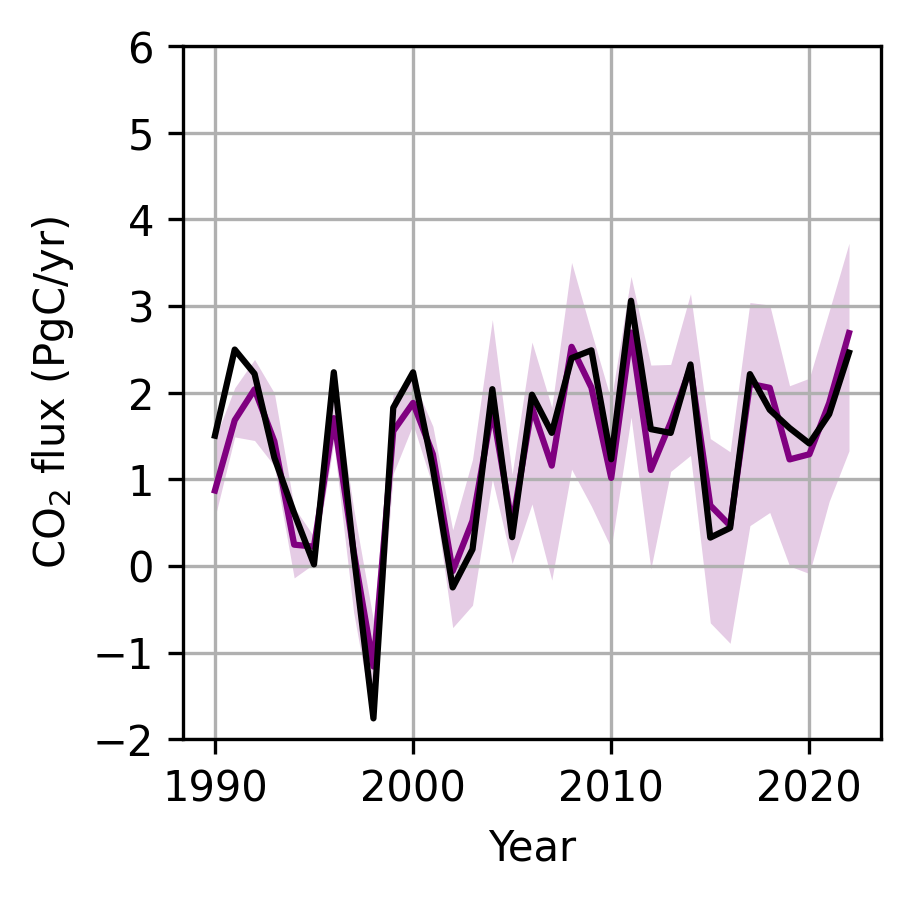

In [64]:
fig, ax = plt.subplots(dpi=300,figsize=(3,3))


global_nbp.mean().loc[1990:].plot(color='purple',ax=ax)

ax.set(ylim=[-2,6],xlabel='year',ylabel='CO${_2}$ flux (PgC/yr)')


ax.fill_between(global_nbp.loc[:,1990:].columns,global_nbp.max().loc[1990:],global_nbp.min().loc[1990:],color='purple',alpha=0.2,lw=0)

(land_sink_nbp.loc[1990:]/1e15).plot(ax=ax,c='k')

ax.grid('--')

<Axes: xlabel='time'>

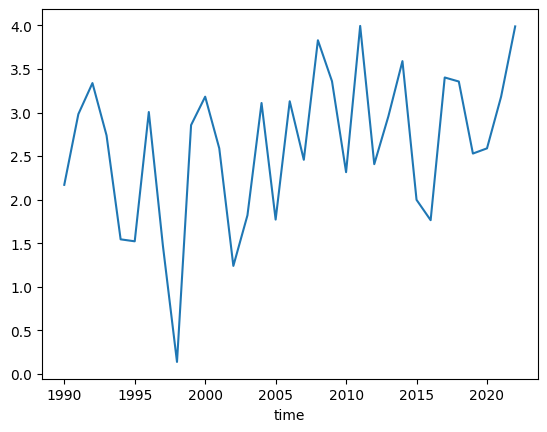